# TP1 - Part 2: Domain-Specific Embeddings

**Day 2 - AI for Sciences Winter School**

**Instructor:** Raphael Cousin

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/racousin/ai_for_sciences/blob/main/day2/tp1_part2.ipynb)

---

## Objectives

In this practical, we explore **domain-specific embeddings** across four scientific domains. Each domain has specialized pre-trained models that understand the unique "language" of that field.

| Domain | Data | Model | What captures "similarity"? |
|--------|------|-------|----------------------------|
| **Text** | Scientific abstracts | SciBERT | Semantic meaning, topic similarity |
| **Molecules** | SMILES strings | ChemBERTa | Chemical structure, properties |
| **Proteins** | Amino acid sequences | ESM-2 | Structural/functional similarity |
| **DNA** | Nucleotide sequences | DNABERT-2 | Functional regions, motifs |

**Key Questions**:
- How do tokenization strategies differ across domains?
- How do domain-specific models capture domain-specific similarity?

In [1]:
!pip download --no-deps -d /tmp git+https://github.com/racousin/ai_for_sciences.git && unzip -l /tmp/*.whl | grep embeddings

  Cloning https://github.com/racousin/ai_for_sciences.git to /private/var/folders/n1/bdjyqqwn5t5cglz8mdg_13900000gn/T/pip-req-build-xxiirxzz
  Running command git clone --filter=blob:none --quiet https://github.com/racousin/ai_for_sciences.git /private/var/folders/n1/bdjyqqwn5t5cglz8mdg_13900000gn/T/pip-req-build-xxiirxzz
  Resolved https://github.com/racousin/ai_for_sciences.git to commit 0a8b7ebf1dc61cf3bbe3d9e31351d0cea1a31b9e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
The file /private/tmp/aiforscience-0.1.0.zip exists. (i)gnore, (w)ipe, (b)ackup, (a)bort ^C

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
ERROR: Operation cancelled by user


---

## Setup

In [ ]:
# Install packages
# !pip install -q git+https://github.com/racousin/ai_for_sciences.git
# !pip install -q transformers torch pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

from aiforscience import (
    load_student_projects,
    get_transformer_embeddings,
    compute_similarity_matrix,
    find_top_similar_pairs,
    find_most_similar,
    plot_similarity_matrix,
    plot_embeddings_tsne,
    print_tokenization_example,
)

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print("Setup complete!")

In [3]:
# Data paths - relative to notebook location
DATA_DIR = "data"

# For Colab, download data if needed
if not os.path.exists(DATA_DIR):
    print("Downloading data files...")
    !mkdir -p data
    !wget -q -O data/student_project.csv https://raw.githubusercontent.com/racousin/ai_for_sciences/main/day2/data/student_project.csv
    !wget -q -O data/molecules_bbbp.csv https://raw.githubusercontent.com/racousin/ai_for_sciences/main/day2/data/molecules_bbbp.csv
    !wget -q -O data/proteins_pfam.csv https://raw.githubusercontent.com/racousin/ai_for_sciences/main/day2/data/proteins_pfam.csv
    !wget -q -O data/dna_histone.csv https://raw.githubusercontent.com/racousin/ai_for_sciences/main/day2/data/dna_histone.csv
    print("Data downloaded!")
else:
    print(f"Data directory found: {DATA_DIR}")

Data directory found: data


---

# Section A: Scientific Text Embeddings

## Context

Scientific text presents unique challenges for language models:
- **Specialized vocabulary**: Terms like "apoptosis", "eigenvalue", "chromatography"
- **Domain-specific meanings**: "Cell" means different things in biology vs. computer science
- **Complex sentence structures**: Scientific writing style differs from general text

**SciBERT** was trained on 1.14M papers from [huggingface](https://www.semanticscholar.org/) covering:
- 18% Computer Science
- 82% Biomedical papers

This domain-specific training helps it understand scientific terminology better than general-purpose models.

## The Data: Your Fellow Students' Projects

We'll embed the research project descriptions from all students in this summer school and explore which projects are semantically similar.

In [4]:
# Load student projects
projects = load_student_projects(os.path.join(DATA_DIR, "student_project.csv"))

print(f"Loaded {len(projects)} student projects:\n")
for i, (author, content) in enumerate(projects.items()):
    # Show first 100 chars of each project
    print(f"{i+1}. {author}: {content[:100]}...\n")

Loaded 18 student projects:

1. Maurits Arif Fathoni Lubis & Tang Zhe: Proposal Title: AI-Based Automated Vectorization of Historical Maps
Background and Problem Statement...

2. TrinidadBorrell: Topological Data Analysis and Graph Variational Autoencoders for Brain Connectivity Classification f...

3. Wenrui GAO: AI- Based Framework for Automated Cell-Type Annotation in Hepatic scRNA-seq

Data.

Objective
To dev...

4. Samantha_Kwah: AI-Based Drug Repurposing for Plasmodium falciparum Using
Multi-Modal Embeddings
Objective
The objec...

5. Shang Ma: Machine Learning Frameworks for AI-Driven Discovery in Interfacial Science

1. Objective
The objecti...

6. Evangelia_Petropoulou: Project Proposal - AI for Sciences Winter School: Benchmarking hybrid RL
and RNNs in sequential deci...

7. Hari Haran Sudhakar: Evaluating machine-learning methods in predicting chemical properties
Introduction
Computational che...

8. Ho Xin Jie Kenneth: CNN-Based Super-Resolution of Satellite Imagery
Objecti

## The Model: SciBERT

**Model**: [`allenai/scibert_scivocab_uncased`](https://huggingface.co/allenai/scibert_scivocab_uncased)

- **Architecture**: BERT-base (12 layers, 768 hidden dimensions)
- **Vocabulary**: 31k tokens from scientific papers ("scivocab")
- **Training**: Masked language modeling on scientific papers

**Alternative to try**: [`sentence-transformers/all-MiniLM-L6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) - a general-purpose sentence embedding model, faster but less specialized.

In [5]:
from transformers import AutoTokenizer, AutoModel

# Load SciBERT
text_tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
text_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
text_model.eval()

print(f"Model loaded: allenai/scibert_scivocab_uncased")
print(f"Hidden size: {text_model.config.hidden_size}")
print(f"Number of layers: {text_model.config.num_hidden_layers}")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Model loaded: allenai/scibert_scivocab_uncased
Hidden size: 768
Number of layers: 12


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

### Understanding the Tokenizer

Let's see how SciBERT tokenizes scientific text. Its vocabulary was built from scientific papers, so it handles technical terms efficiently.

In [6]:
# Tokenizer statistics
print(f"SciBERT Vocabulary Size: {text_tokenizer.vocab_size:,} tokens")

# Example tokenization of scientific terms
scientific_terms = [
    "machine learning for drug discovery",
    "electroencephalography signal analysis",
    "convolutional neural network architecture",
    "protein folding and molecular dynamics"
]

print("\nTokenization examples:")
for term in scientific_terms:
    tokens = text_tokenizer.tokenize(term)
    print(f"\n  '{term}'")
    print(f"  -> {tokens} ({len(tokens)} tokens)")

SciBERT Vocabulary Size: 31,090 tokens

Tokenization examples:

  'machine learning for drug discovery'
  -> ['machine', 'learning', 'for', 'drug', 'discovery'] (5 tokens)

  'electroencephalography signal analysis'
  -> ['electroencephal', '##ography', 'signal', 'analysis'] (4 tokens)

  'convolutional neural network architecture'
  -> ['convolutional', 'neural', 'network', 'architecture'] (4 tokens)

  'protein folding and molecular dynamics'
  -> ['protein', 'folding', 'and', 'molecular', 'dynamics'] (5 tokens)


### Computing Project Embeddings

In [7]:
# Get author names and project descriptions
authors = list(projects.keys())
descriptions = list(projects.values())

# Compute embeddings using mean pooling
print(f"Computing embeddings for {len(authors)} projects...")
text_embeddings = get_transformer_embeddings(
    descriptions, 
    text_tokenizer, 
    text_model, 
    max_length=512,
    pooling='mean'  # Mean pooling over all tokens
)

print(f"Embedding shape: {text_embeddings.shape}")
print(f"-> {len(authors)} projects, each with {text_embeddings.shape[1]} dimensions")

Computing embeddings for 18 projects...
Embedding shape: (18, 768)
-> 18 projects, each with 768 dimensions


### Visualizing Project Similarity

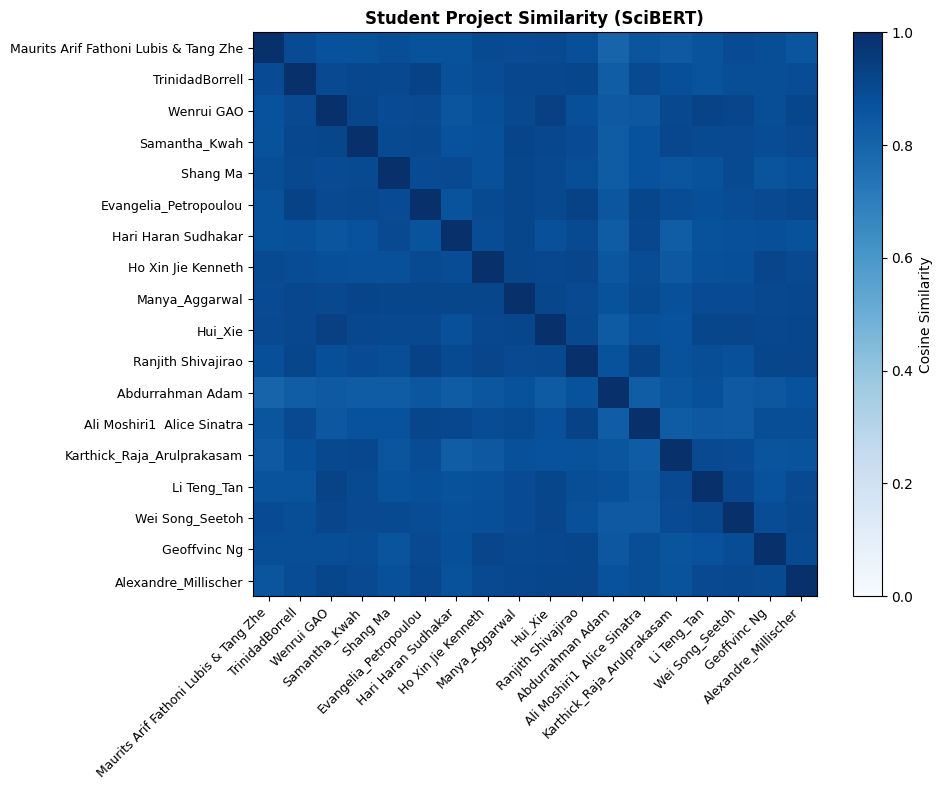

In [8]:
# Compute similarity matrix
text_sim = compute_similarity_matrix(text_embeddings)

# Plot similarity matrix
fig = plot_similarity_matrix(text_sim, authors, title='Student Project Similarity (SciBERT)')
plt.show()

In [9]:
# Find most similar project pairs
top_pairs = find_top_similar_pairs(text_sim, authors, top_k=10)

print("Most similar project pairs:\n")
for sim, author1, author2 in top_pairs:
    print(f"  {sim:.3f}: {author1} <-> {author2}")

Most similar project pairs:

  0.935: Wenrui GAO <-> Hui_Xie
  0.929: Evangelia_Petropoulou <-> Ranjith Shivajirao
  0.928: Ranjith Shivajirao <-> Ali Moshiri1  Alice Sinatra
  0.926: TrinidadBorrell <-> Evangelia_Petropoulou
  0.925: Wenrui GAO <-> Li Teng_Tan
  0.922: Samantha_Kwah <-> Manya_Aggarwal
  0.917: Hui_Xie <-> Wei Song_Seetoh
  0.915: Wenrui GAO <-> Wei Song_Seetoh
  0.914: Ranjith Shivajirao <-> Alexandre_Millischer
  0.914: Ho Xin Jie Kenneth <-> Ranjith Shivajirao


In [ ]:
# Visualize in 2D using t-SNE
fig = plot_embeddings_tsne(
    text_embeddings, 
    labels=authors, 
    title='Student Projects in Embedding Space (t-SNE)',
    annotate=True
)
plt.show()

### Exercise 1: Explore Your Own Text

Add your own research description, an arXiv abstract, or any scientific text to see where it falls in the embedding space!

In [ ]:
# TODO: Paste your own text here!
# Examples:
# - Your research project abstract
# - An arXiv paper abstract (copy-paste from https://arxiv.org/)
# - A sentence describing a research topic

my_text = "Your research description or abstract here"  # <-- Modify this!

# Compute embedding for your text
my_embedding = get_transformer_embeddings(
    [my_text], 
    text_tokenizer, 
    text_model,
    pooling='mean'
)

# Find most similar projects
results = find_most_similar(my_embedding[0], text_embeddings, authors, top_k=5)

print(f"Your text: {my_text[:80]}...\n")
print("Most similar projects:")
for sim, author in results:
    print(f"  {sim:.3f}: {author}")

### Question 1: Token Size and Representation

Run the cell below to analyze how different scientific terms are tokenized:

In [ ]:
# Compare tokenization of domain-specific vs common words
test_words = [
    ("DNA", "Common scientific term"),
    ("deoxyribonucleic", "Full chemical name"),
    ("CRISPR", "Modern technique"),
    ("transformer", "ML architecture"),
    ("electroencephalography", "Medical term"),
    ("EEG", "Abbreviation"),
]

print("How SciBERT tokenizes different terms:\n")
for word, description in test_words:
    tokens = text_tokenizer.tokenize(word)
    print(f"  {word:25} ({description:20}) -> {tokens}")

**Questions to consider:**

1. Why does "DNA" get tokenized as a single token while "deoxyribonucleic" is split?
2. What does this tell you about the vocabulary's training data?
3. How might tokenization affect the model's understanding of rare scientific terms?

---

### Optional: Try an Alternative Model

Uncomment the code below to compare with `sentence-transformers/all-MiniLM-L6-v2`:

In [ ]:
# # Alternative: Sentence-BERT (general purpose, faster)
# from sentence_transformers import SentenceTransformer
# 
# alt_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# alt_embeddings = alt_model.encode(descriptions)
# 
# alt_sim = compute_similarity_matrix(alt_embeddings)
# fig = plot_similarity_matrix(alt_sim, authors, title='Project Similarity (MiniLM)')
# plt.show()
# 
# # Compare: Do the similarity patterns differ?

---

# Section B: Molecular Embeddings

## Context: What is SMILES?

**SMILES** (Simplified Molecular Input Line Entry System) is a text notation for representing molecules:

```
Aspirin:     CC(=O)OC1=CC=CC=C1C(=O)O
Caffeine:    CN1C=NC2=C1C(=O)N(C(=O)N2C)C
Ethanol:     CCO
Benzene:     c1ccccc1
```

**Key SMILES notation**:
- **Letters**: Atoms (C=carbon, N=nitrogen, O=oxygen, etc.)
- **Numbers**: Ring closures (1, 2, 3...)
- **Parentheses**: Branches
- **=, #**: Double and triple bonds
- **Lowercase**: Aromatic atoms (c, n, o)

**ChemBERTa** is a BERT-style model trained on ~77M molecules from the [ZINC database](https://zinc.docking.org/), learning to understand molecular structure from SMILES strings.

## The Data: Blood-Brain Barrier Permeability (BBBP)

The **blood-brain barrier (BBB)** is a selective membrane protecting the brain. For drugs targeting the central nervous system, BBB permeability is crucial.

- **BBB-permeable**: Drug can cross into the brain
- **BBB-impermeable**: Drug cannot reach the brain

This dataset contains molecules labeled by their BBB permeability.

In [ ]:
# Load molecule dataset
mol_df = pd.read_csv(os.path.join(DATA_DIR, "molecules_bbbp.csv"))

print(f"Dataset shape: {mol_df.shape}")
print(f"\nColumns: {list(mol_df.columns)}")
print(f"\nLabel distribution:")
print(mol_df['label_name'].value_counts())

print(f"\nExample SMILES:")
for idx in [0, 5, 10]:
    row = mol_df.iloc[idx]
    print(f"  {row['SMILES'][:50]:50} -> {row['label_name']}")

## The Model: ChemBERTa

**Model**: [`seyonec/ChemBERTa-zinc-base-v1`](https://huggingface.co/seyonec/ChemBERTa-zinc-base-v1)

- **Architecture**: RoBERTa-base (12 layers, 768 hidden dimensions)
- **Vocabulary**: ~600 tokens for SMILES characters and substructures
- **Training**: Masked language modeling on 77M SMILES from ZINC database

**Alternative to try**: [`DeepChem/ChemBERTa-77M-MTR`](https://huggingface.co/DeepChem/ChemBERTa-77M-MTR) - trained with multi-task learning on molecular properties.

In [ ]:
# Load ChemBERTa
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model.eval()

print(f"Model loaded: seyonec/ChemBERTa-zinc-base-v1")
print(f"Hidden size: {chem_model.config.hidden_size}")

### Understanding SMILES Tokenization

In [ ]:
# ChemBERTa tokenizer statistics
print(f"ChemBERTa Vocabulary Size: {chem_tokenizer.vocab_size:,} tokens")

# Example tokenization
example_molecules = [
    ("CCO", "Ethanol"),
    ("c1ccccc1", "Benzene"),
    ("CC(=O)OC1=CC=CC=C1C(=O)O", "Aspirin"),
]

print("\nSMILES tokenization examples:")
for smiles, name in example_molecules:
    tokens = chem_tokenizer.tokenize(smiles)
    print(f"\n  {name} ({smiles})")
    print(f"  -> {tokens} ({len(tokens)} tokens)")

### Computing Molecular Embeddings

In [ ]:
# Sample molecules for visualization
n_sample = 100
mol_sample = mol_df.sample(n=n_sample, random_state=42).reset_index(drop=True)

print(f"Computing embeddings for {n_sample} molecules...")
mol_embeddings = get_transformer_embeddings(
    mol_sample['SMILES'].tolist(),
    chem_tokenizer,
    chem_model,
    pooling='cls'  # Use [CLS] token for molecules
)

print(f"Embedding shape: {mol_embeddings.shape}")

### Visualizing Molecular Embedding Space

Do BBB-permeable and BBB-impermeable molecules cluster separately in the embedding space?

In [ ]:
# t-SNE visualization with class labels
fig = plot_embeddings_tsne(
    mol_embeddings,
    categories=mol_sample['label_name'].tolist(),
    title='Molecular Embedding Space (ChemBERTa)'
)
plt.show()

### Molecular Similarity Matrix

In [ ]:
# Compute similarity matrix for a smaller subset (for visualization)
n_viz = 20
mol_viz = mol_sample.head(n_viz)
mol_viz_emb = mol_embeddings[:n_viz]

mol_sim = compute_similarity_matrix(mol_viz_emb)

# Create labels showing SMILES fragment + class
mol_labels = [f"{s[:15]}... ({l[4:]})" for s, l in 
              zip(mol_viz['SMILES'], mol_viz['label_name'])]

fig = plot_similarity_matrix(mol_sim, mol_labels, 
                             title='Molecular Similarity (ChemBERTa)',
                             figsize=(12, 10))
plt.show()

### Molecular Similarity Search

In [ ]:
# Find similar molecules to aspirin
aspirin = "CC(=O)OC1=CC=CC=C1C(=O)O"

# Get aspirin embedding
aspirin_emb = get_transformer_embeddings([aspirin], chem_tokenizer, chem_model, pooling='cls')

# Find similarities
mol_sim_scores = compute_similarity_matrix(
    np.vstack([aspirin_emb, mol_embeddings])
)[0, 1:]  # First row, excluding self-similarity

print("Query: Aspirin")
print(f"SMILES: {aspirin}\n")
print("Most similar molecules in dataset:")
for idx in mol_sim_scores.argsort()[::-1][:5]:
    row = mol_sample.iloc[idx]
    print(f"  {mol_sim_scores[idx]:.3f}: {row['SMILES'][:40]}... ({row['label_name']})")

### Question 2: Molecular Embeddings

Looking at the t-SNE visualization and similarity matrix:

1. Are BBB-permeable and impermeable molecules clearly separated?
2. What does this tell us about whether BBB permeability is related to the molecular structure features that ChemBERTa captures?
3. Why might there be overlap between the two classes? (Think about what chemical features influence BBB permeability)

---

### Optional: Try ChemBERTa-77M-MTR

Uncomment to compare with the multi-task trained version:

In [ ]:
# # Alternative: ChemBERTa trained with multi-task regression
# alt_chem_tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
# alt_chem_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
# alt_chem_model.eval()
# 
# alt_mol_embeddings = get_transformer_embeddings(
#     mol_sample['SMILES'].tolist(),
#     alt_chem_tokenizer,
#     alt_chem_model,
#     pooling='cls'
# )
# 
# fig = plot_embeddings_tsne(
#     alt_mol_embeddings,
#     categories=mol_sample['label_name'].tolist(),
#     title='Molecular Embedding Space (ChemBERTa-77M-MTR)'
# )
# plt.show()

---

# Section C: Protein Embeddings

## Context

Proteins are sequences of **amino acids** - 20 building blocks denoted by single letters:

```
A (Alanine)      G (Glycine)      M (Methionine)    S (Serine)
C (Cysteine)     H (Histidine)    N (Asparagine)    T (Threonine)
D (Aspartate)    I (Isoleucine)   P (Proline)       V (Valine)
E (Glutamate)    K (Lysine)       Q (Glutamine)     W (Tryptophan)
F (Phenylalanine) L (Leucine)     R (Arginine)      Y (Tyrosine)
```

Example protein sequence: `MSKIIEYDETARRAIEAGVNTLADAVRVTLGPRGR...`

**ESM-2** (Evolutionary Scale Modeling) from Meta AI was trained on **millions of protein sequences** from UniRef. It learns:
- Structural information from sequence alone
- Evolutionary relationships between proteins
- Functional motifs and domains

## The Data: Protein Families (Pfam)

Proteins are grouped into **families** based on evolutionary relationships and similar functions. Proteins in the same family often:
- Share similar 3D structures
- Perform related biological functions
- Have common evolutionary ancestors

In [ ]:
# Load protein dataset
prot_df = pd.read_csv(os.path.join(DATA_DIR, "proteins_pfam.csv"))

print(f"Dataset shape: {prot_df.shape}")
print(f"\nProtein families:")
print(prot_df['family_name'].value_counts())

print(f"\nExample sequence (first 60 amino acids):")
print(f"  {prot_df.iloc[0]['sequence'][:60]}...")
print(f"  Family: {prot_df.iloc[0]['family_name']}")

## The Model: ESM-2

**Model**: [`facebook/esm2_t6_8M_UR50D`](https://huggingface.co/facebook/esm2_t6_8M_UR50D)

- **Architecture**: Transformer (6 layers, 320 hidden dimensions)
- **Vocabulary**: 33 tokens (20 amino acids + special tokens)
- **Training**: Masked language modeling on UniRef50 (millions of protein sequences)
- **Size**: 8M parameters (smallest ESM-2, good for tutorials)

**Alternative to try**: [`Rostlab/prot_bert`](https://huggingface.co/Rostlab/prot_bert) - BERT trained on protein sequences with different tokenization.

In [ ]:
from transformers import EsmTokenizer, EsmModel

# Load ESM-2
esm_tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model.eval()

print(f"Model loaded: facebook/esm2_t6_8M_UR50D")
print(f"Hidden size: {esm_model.config.hidden_size}")

### Understanding Protein Tokenization

In [ ]:
# ESM tokenizer statistics
print(f"ESM-2 Vocabulary Size: {esm_tokenizer.vocab_size} tokens")
print(f"\nVocabulary: {list(esm_tokenizer.get_vocab().keys())[:30]}...")

# Example tokenization
example_seq = "MSKIIEYDETARRAIE"
tokens = esm_tokenizer.tokenize(example_seq)
print(f"\nExample sequence: {example_seq}")
print(f"Tokens: {tokens}")
print(f"\nNote: ESM-2 uses single amino acid tokens (no subword tokenization)")

### Computing Protein Embeddings

In [ ]:
# Sample proteins (balanced across families)
n_per_family = 15
prot_sample = prot_df.groupby('family_name').head(n_per_family).reset_index(drop=True)

print(f"Computing embeddings for {len(prot_sample)} proteins...")

# Truncate long sequences for speed
sequences = [seq[:200] for seq in prot_sample['sequence'].tolist()]

prot_embeddings = get_transformer_embeddings(
    sequences,
    esm_tokenizer,
    esm_model,
    max_length=200,
    pooling='mean'  # Mean pooling for proteins
)

print(f"Embedding shape: {prot_embeddings.shape}")

### Visualizing Protein Families

Do proteins from the same family cluster together in the embedding space?

In [ ]:
# t-SNE visualization with family labels
fig = plot_embeddings_tsne(
    prot_embeddings,
    categories=prot_sample['family_name'].tolist(),
    title='Protein Embedding Space (ESM-2)'
)
plt.show()

### Protein Family Similarity Matrix

In [ ]:
# Compute similarity matrix for subset
n_viz = 20
prot_viz = prot_sample.head(n_viz)
prot_viz_emb = prot_embeddings[:n_viz]

prot_sim = compute_similarity_matrix(prot_viz_emb)

# Create labels showing UniProt ID + family
prot_labels = [f"{uid[:8]}..." for uid in prot_viz['uniprot_id']]

fig = plot_similarity_matrix(prot_sim, prot_labels,
                             title='Protein Similarity (ESM-2)',
                             figsize=(10, 8))
plt.show()

# Show family for each protein
print("\nProtein families:")
for i, (uid, fam) in enumerate(zip(prot_viz['uniprot_id'], prot_viz['family_name'])):
    print(f"  {i}: {uid[:8]}... -> {fam}")

### Question 3: Protein Family Clustering

Looking at the protein embedding visualization:

1. Are proteins from the same family clustered together?
2. Which families seem most distinct? Most overlapping?
3. What biological properties might the embedding capture that cause this clustering? (Consider: sequence patterns, structural features, functional domains)

---

### Optional: Try ProtBERT

Uncomment to compare with ProtBERT:

In [ ]:
# # Alternative: ProtBERT
# from transformers import BertTokenizer, BertModel
# 
# prot_bert_tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
# prot_bert_model = BertModel.from_pretrained("Rostlab/prot_bert")
# prot_bert_model.eval()
# 
# # ProtBERT expects space-separated amino acids
# sequences_spaced = [' '.join(seq[:200]) for seq in prot_sample['sequence'].tolist()]
# 
# alt_prot_embeddings = get_transformer_embeddings(
#     sequences_spaced,
#     prot_bert_tokenizer,
#     prot_bert_model,
#     pooling='mean'
# )
# 
# fig = plot_embeddings_tsne(
#     alt_prot_embeddings,
#     categories=prot_sample['family_name'].tolist(),
#     title='Protein Embedding Space (ProtBERT)'
# )
# plt.show()

---

# Section D: DNA Embeddings

## Context

DNA sequences use 4 nucleotides: **A** (Adenine), **T** (Thymine), **C** (Cytosine), **G** (Guanine)

```
Example: ATCGATCGATCG...
```

**Histone modifications** are chemical changes to histone proteins around which DNA wraps. These modifications affect:
- Gene expression (turning genes on/off)
- DNA accessibility
- Chromatin structure

**DNABERT-2** learns representations from DNA sequences that capture:
- Sequence motifs and patterns
- Functional elements (promoters, enhancers, etc.)
- Regulatory signals

## The Data: Histone Modification Prediction

This dataset contains DNA sequences labeled by whether the surrounding histone (H3) is modified or not.

In [ ]:
# Load DNA dataset
dna_df = pd.read_csv(os.path.join(DATA_DIR, "dna_histone.csv"))

print(f"Dataset shape: {dna_df.shape}")
print(f"\nLabel distribution:")
print(dna_df['label_name'].value_counts())
print(f"\nSequence length: {len(dna_df.iloc[0]['sequence'])} bp")
print(f"\nExample sequence (first 60 nucleotides):")
print(f"  {dna_df.iloc[0]['sequence'][:60]}...")

## The Model: DNABERT-2

**Model**: [`zhihan1996/DNABERT-2-117M`](https://huggingface.co/zhihan1996/DNABERT-2-117M)

- **Architecture**: BERT with Byte-Pair Encoding for DNA
- **Vocabulary**: BPE-based, learns subword patterns from DNA
- **Training**: Multi-species genome data
- **Innovation**: Unlike earlier DNABERT (k-mer based), DNABERT-2 uses BPE which can learn variable-length motifs

**Alternative to try**: [`InstaDeepAI/nucleotide-transformer-500m-human-ref`](https://huggingface.co/InstaDeepAI/nucleotide-transformer-500m-human-ref) - larger model focused on human genome.

In [ ]:
# Load DNABERT-2
dna_tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
dna_model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
dna_model.eval()

print(f"Model loaded: zhihan1996/DNABERT-2-117M")
print(f"Hidden size: {dna_model.config.hidden_size}")

### Understanding DNA Tokenization

In [ ]:
# DNABERT-2 tokenizer statistics
print(f"DNABERT-2 Vocabulary Size: {dna_tokenizer.vocab_size:,} tokens")

# Example tokenization
example_dna = "ATCGATCGATCGATCGATCG"
tokens = dna_tokenizer.tokenize(example_dna)
print(f"\nExample DNA: {example_dna}")
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")

# Compare with a repetitive vs random sequence
repetitive = "ATATATATAT"
random_seq = "ACTGCTAGCT"
print(f"\nRepetitive ({repetitive}): {dna_tokenizer.tokenize(repetitive)}")
print(f"Random ({random_seq}): {dna_tokenizer.tokenize(random_seq)}")

### Computing DNA Embeddings

In [ ]:
# Sample DNA sequences
n_sample = 100
dna_sample = dna_df.sample(n=n_sample, random_state=42).reset_index(drop=True)

print(f"Computing embeddings for {n_sample} DNA sequences...")

# Truncate for speed
sequences = [seq[:200] for seq in dna_sample['sequence'].tolist()]

dna_embeddings = get_transformer_embeddings(
    sequences,
    dna_tokenizer,
    dna_model,
    max_length=200,
    pooling='mean'
)

print(f"Embedding shape: {dna_embeddings.shape}")

### Visualizing DNA Embedding Space

In [ ]:
# t-SNE visualization with modification labels
fig = plot_embeddings_tsne(
    dna_embeddings,
    categories=dna_sample['label_name'].tolist(),
    title='DNA Embedding Space (DNABERT-2)'
)
plt.show()

### DNA Similarity Matrix

In [ ]:
# Compute similarity matrix for subset
n_viz = 20
dna_viz = dna_sample.head(n_viz)
dna_viz_emb = dna_embeddings[:n_viz]

dna_sim = compute_similarity_matrix(dna_viz_emb)

# Create labels showing first nucleotides + class
dna_labels = [f"{seq[:8]}...({l.split('_')[1][:3]})" 
              for seq, l in zip(dna_viz['sequence'], dna_viz['label_name'])]

fig = plot_similarity_matrix(dna_sim, dna_labels,
                             title='DNA Sequence Similarity (DNABERT-2)',
                             figsize=(10, 8))
plt.show()

### Question 4: DNA Embeddings

Looking at the DNA embedding visualization:

1. Are H3-modified and unmodified sequences separable in the embedding space?
2. What does this suggest about the relationship between sequence patterns and histone modification?
3. Compare this to the molecular embeddings (Section B) - which shows better class separation? What might explain the difference?

---

### Optional: Try Nucleotide Transformer

Uncomment to try a larger DNA model:

In [ ]:
# # Alternative: Nucleotide Transformer (larger model)
# # Note: This model is larger and may be slower
# 
# alt_dna_tokenizer = AutoTokenizer.from_pretrained(
#     "InstaDeepAI/nucleotide-transformer-500m-human-ref",
#     trust_remote_code=True
# )
# alt_dna_model = AutoModel.from_pretrained(
#     "InstaDeepAI/nucleotide-transformer-500m-human-ref",
#     trust_remote_code=True
# )
# alt_dna_model.eval()
# 
# alt_dna_embeddings = get_transformer_embeddings(
#     sequences[:50],  # Fewer samples for speed
#     alt_dna_tokenizer,
#     alt_dna_model,
#     pooling='mean'
# )
# 
# fig = plot_embeddings_tsne(
#     alt_dna_embeddings,
#     categories=dna_sample['label_name'].tolist()[:50],
#     title='DNA Embedding Space (Nucleotide Transformer)'
# )
# plt.show()

---

# Summary: Key Takeaways

> **Pre-trained embeddings are powerful features.** Even without fine-tuning, these models capture meaningful relationships in scientific data.


---

## Reflection Questions

1. **For your research domain**, which pre-trained model might be most useful? Does one exist for your specific data type?

2. **What properties** would you want embeddings to capture in your domain? How would you evaluate if a model captures them?

3. **What downstream tasks** could you solve with good embeddings? Consider:
   - Classification (categorizing samples)
   - Clustering (grouping similar samples)
   - Retrieval (finding similar samples to a query)
   - Visualization (understanding data structure)

4. **Tokenization trade-offs**: How does the tokenization strategy affect what the model can learn? Think about:
   - Vocabulary size vs. sequence length
   - Domain-specific vs. general vocabulary
   - Character-level vs. subword vs. word-level